<div style="text-align: right"> Madison Rusch </div>

<left>FINM 36700</left> 
<br>
<left>Autumn 2022</left>

<h2><center>Midterm #1 </center></h2>

### 1 Short Answer

1. Suppose an endowment is optimizing across multiple asset classes: equities, bonds, commodities, and currencies. They are considering whether to add cryptocurrencies as a new asset class for their mean-variance optimization. Do you think it is reasonable to make this decision based on whether the Sharpe ratio of crypto is higher than the Sharpe ratios of their current asset classes? Explain.

    - <p>No, I do not think this is reasonable. Optimization more generally depends on the covariance between assets, so adding in cryptocurrency as an additional asset may not be a good move without first checking how it is correlated with the other assets already included. If they find that there is low correlation, then it is perhaps reasonable to include it.</p>

2. True or False. (And explain your reason.) We found that small changes in estimated mean returns have large impacts on the mean-variance
frontier. (By “frontier”, we mean the set of achievable means and variances.)

    - <p>True. We found in the discussion of the first homework that MV Optimization is very fragile in regards to the mean. Small changes in the mean return can yield large changes in the portfolio weights</p>

3. One might estimate the Value-at-Risk directly from the historic data, (the empirical cdf) or from using an approximation based on the normal distribution. Which did we find performed better in actual data? How did we judge which performed better?

    - <p>We found that the VaR estimated from the approximation of the normal distribution performed better. We found that data using this VaR actually did fall below the fifth quantile closer to 5% of the time than the data taken compared to the historic VaR</p>

4. What approach does Harvard take to getting more realistic weights? What is a problem with this approach?

    - <p>They bounded their asset classes, to prevent the MV Optimization from providing crazy long or short positions. The problem with this is that the bounds tend to shape your solution, as the MV Optimizer will at times maximize or minimize positions right up to those bounds</p>

5. What aspect of tools such as Ridge regression and LASSO regression are useful in meanvariance optimization? That is, what problem in the classic MV solution are they addressing?

    - <p>Ridge and Lasso are addressing the issue of large long and short positions in the classic MV Solution. Ridge by penalizing large positions, and Lasso by keeping only significant positions.</p>

6. Consider three series: HFRIFWI, MLEIFCTR, and HDG. Explain how they differ. That is, why were we interested in all three with regard to hedge-fund replication?

    - <p>HFRIFWI was an index that tracked hedge fund returns, which you could not invest in. MLEIFCTR was Merrill Lynch's Factor Model Index, also non-investable. It was a benchmark index based on the Merrill Lynch replication of HFRIFWI, based on six passive instruments. Finally, HDG was ProShares' ETF version of replicating that index, but was instead actively traded.</p>


### 2 Allocation

1. Report the weights of the Global Minimum Variance (GMV) portfolio, ωv, and the weights of the Tangency portfolio, ωt.

In [168]:
# Some Python Code for importing packages/data
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
import scipy
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 4)

# Read excel file, sheet
data = pd.read_excel('../data/midterm_1.xlsx', 'total returns')
data = data.set_index('date')
data.head()

,CL1,GC1,KC1,ES1,BP1
date,,,,,
2009-01-31,-0.1135,0.0486,0.0611,-0.0861,-0.0078
2009-02-28,0.0447,0.0152,-0.0795,-0.1073,-0.0083
2009-03-31,0.0879,-0.0211,0.0344,0.0872,0.0017
2009-04-30,-0.0138,-0.0365,-0.0065,0.0947,0.0329
2009-05-31,0.2874,0.0983,0.1855,0.0552,0.0889


#### 2.1 Global Minimum Variance Portfolio

In [169]:
def compute_gmv(returns):
    sigma = returns.cov()
    n = sigma.shape[0]
    sigma_inv = np.linalg.inv(sigma)
    # I recognize mu is uncessary but want it for the index
    mu = returns.mean()
    
    weights = (sigma_inv @ np.ones(n)) / (np.ones(n) @ sigma_inv @ np.ones(n))
    
    return pd.Series(weights, index=mu.index)

print("The weights of the GMV Portfolio are: ")
compute_gmv(data)

The weights of the GMV Portfolio are: 


CL1   -0.0307
GC1    0.1791
KC1   -0.0106
ES1    0.0922
BP1    0.7700
dtype: float64

#### 2.1 Tangency Portfolio


In [170]:
def compute_tangency(excessReturnMatrix):
    # Get the covariance matrix based on excess returns
    sigma = excessReturnMatrix.cov()
    
    # Get the number of asset classes (in this example should be 11)
    n = sigma.shape[0]
    
    # Get the vector of mean excess returns
    mu = excessReturnMatrix.mean()
    
    # Get sigma inverse
    sigma_inv = np.linalg.inv(sigma)
    
    # Now we have all the pieces, do the calculation
    weights = (sigma_inv @ mu) / (np.ones(n) @ sigma_inv @ mu)
    
    # Convert back to a Series for convenience
    return pd.Series(weights, index=mu.index)

tangency_weights = compute_tangency(data)
print("The weights of the tangency portfolio are: ")
tangency_weights

The weights of the tangency portfolio are: 


CL1   -0.1281
GC1    1.1911
KC1    0.0978
ES1    4.2200
BP1   -4.3808
dtype: float64

#### 2.2 What are the weights of the optimal portfolio, ω∗, with a targeted total mean return of 0.20 annualized, (0.20/12 per month)? What is the volatility of this portfolio allocation?


In [171]:
def compute_weights(returnsData, tangency_weights, target_return):
    mu = returnsData.mean()
    sigma = returnsData.cov()
    n = sigma.shape[0]
    scalar = ((np.ones(n) @ np.linalg.inv(sigma) @ mu) / (mu @ np.linalg.inv(sigma) @ mu)) * target_return
    return scalar * tangency_weights

optimized_portfolio = compute_weights(data, tangency_weights, 0.02/12)
print("The weights of the optimized portfolio are: ")
print(optimized_portfolio)

def portfolio_stats(excessReturnData, portfolio_weights):
    # Calculate the mean by multiplying the mean excess returns by the tangency weights and annualizing
    mean = excessReturnData.mean() @ portfolio_weights * 12

    # Volatility = sqrt(variance), and by class notes: variance = allocation_matrix * covariance_matrix * allocation_matrix
    # Annualize the result with sqrt(12)
    vol = np.sqrt(portfolio_weights @ excessReturnData.cov() @ portfolio_weights) * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio], 
        index = ['Mean', 'Volatility', 'mean-to-vol'], 
        columns = ['Portfolio Stats']), 4)

vol = portfolio_stats(data, optimized_portfolio)
print(vol)

print(f"The volatility of the optimized portfolio is 0.0182")

The weights of the optimized portfolio are: 
CL1   -0.0040
GC1    0.0370
KC1    0.0030
ES1    0.1310
BP1   -0.1359
dtype: float64
             Portfolio Stats
Mean                  0.0200
Volatility            0.0182
mean-to-vol           1.0967
The volatility of the optimized portfolio is 0.0182


#### 2.3 Suppose we re-did this problem assuming the existence of a risk-free rate. Would the solution with mean return of 0.20 be guaranteed to have less than or equal volatility as the solution above, where we did not have a risk-free rate? Why?

Yes. By introducing a risk free rate, you get a better risk return tradeoff than with the parabola (which does not have the risk free return rate). If you keep your target return the same, your risk (volatility) will go down with the inclusion of the risk free rate- or at least remain the same.


### 3 Hedging & Replication

#### 3.1 Report the last five values of the timeseries of alpha and beta estimates.

In [172]:
y = data['ES1']
X = sm.add_constant(data['BP1'])

rolling_model = RollingOLS(y, X, window=36)
rolling_betas = rolling_model.fit().params.copy()
rolling_betas.tail(5)

,const,BP1
date,,
2022-02-28,0.0137,1.1789
2022-03-31,0.0144,1.1442
2022-04-30,0.0123,1.2476
2022-05-31,0.0130,1.1866
2022-06-30,0.0102,1.2518


#### 3.2 Report the last five values of the timeseries, r∗


In [173]:
r_star = (rolling_betas * X).sum(axis=1,skipna=False)
r_star.tail(5)

date
2022-02-28    0.0102
2022-03-31   -0.0098
2022-04-30   -0.0383
2022-05-31    0.0136
2022-06-30   -0.0301
dtype: float64

#### 3.3 Report the mean, volatility and mean-to-vol ratio of this replicated position, r∗. Annualize the statistics.

In [174]:
def portfolio_stats_2(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio], 
        index = ['Mean', 'Volatility', 'mean-to-vol']), 4)
    
portfolio_stats_2(r_star)

,0
Mean,0.1263
Volatility,0.0625
mean-to-vol,2.0198


#### 3.4  How correlated is this replicated position, r∗, to ES1?

In [175]:
data['R Star'] = r_star
print(f"When looking at the correlation between ES1 and r*, we find that they are only correlated with a value of {round(data.corr().loc['ES1', 'R Star'], 5)}. This seems like a rather low correlation, considering other cases we've seen in class.")

When looking at the correlation between ES1 and r*, we find that they are only correlated with a value of 0.52104. This seems like a rather low correlation, considering other cases we've seen in class.


### 4 Modeling Risk
#### 4.1 Compare the performance statistics between ES1, GC1, and the 50/50 portfolio. Annualize mean and volatility.

In [176]:
risk_data = data.copy()
risk_data = risk_data.drop(columns=['CL1', 'KC1', 'BP1', 'R Star'])
risk_data['50/50'] = (risk_data['ES1']) * .5 + (risk_data['GC1'])*.5
risk_data.head()

,GC1,ES1,50/50
date,,,
2009-01-31,0.0486,-0.0861,-0.0187
2009-02-28,0.0152,-0.1073,-0.0461
2009-03-31,-0.0211,0.0872,0.0330
2009-04-30,-0.0365,0.0947,0.0291
2009-05-31,0.0983,0.0552,0.0767


In [177]:
def maximumDrawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max

        max_drawdown = drawdown.min()
        end_date = drawdown.idxmin()
        summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

        for col in drawdown:
            summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
            recovery = (drawdown.loc[end_date[col]:,col])
            try:
                summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
            except:
                summary.loc[col,'Recover'] = pd.to_datetime(None)

            summary['Peak'] = pd.to_datetime(summary['Peak'])
            try:
                summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
            except:
                summary['Duration (to Recover)'] = None

            summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

        return summary  

def portfolio_stats(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio], 
        index = ['Mean', 'Volatility', 'mean-to-vol']), 4)

portfolio_stats(risk_data)

,GC1,ES1,50/50
Mean,0.0540,0.1291,0.0916
Volatility,0.1601,0.1511,0.1141
mean-to-vol,0.3373,0.8547,0.8026


In [178]:
maximumDrawdown(risk_data)

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
GC1,-0.4296,2011-08-31,2015-12-31,NaN,None
ES1,-0.2032,2019-12-31,2020-03-31,2020-07-31 00:00:00,None
50/50,-0.1210,2022-03-31,2022-06-30,None,None


<AxesSubplot: >

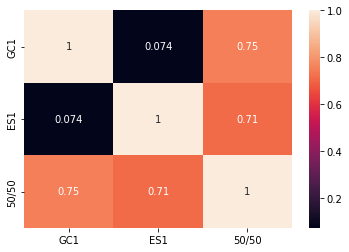

In [179]:
corrmat = risk_data.corr()
sns.heatmap(corrmat,annot=True)

#### 4.2 How does the 50/50 portfolio compare to the individual components in terms of volatility, maximum drawdown, and mean-to-vol ratio? Is this as we would expect from the portfolio theory?

In terms of volatility, the 50/50 portfolio is less volatile than either GC1 or ES1. It's maximum drawdown is also less, while it's Mean to Vol Ratio falls somewhere in the middle of the other two. This is not unexpected, given there is a low correlation between GC1 and ES1. By combining two relatively uncorrelated assets, we've reduced the risk of the third portfolio. Correspondingly, the maximum drawdown (or maximum loss) of the combined portfolio is less. Because the mean (return) of the 50/50 portfolio lies between the returns of the assets that make it up, it is also not a surprise that its Mean to Vol ratio also lies in the middle.

#### 4.3 Calculate the 1-period, 1% CVaR of the 50/50 portfolio analytically.



In [180]:
# a) Volatility (Expanding Series)
sigma_expanding = risk_data['50/50'].expanding().std()

# b) Volatility (Rolling Series)
sigma_rolling = risk_data['50/50'].rolling(24).std()

q = 0.01
z = scipy.stats.norm.ppf(q)
coef_CVaR = -scipy.stats.norm().cdf(z)/q
CVaR_data = pd.DataFrame()
risk_data['Expanding CVaR'] = sigma_expanding*coef_CVaR
risk_data['Rolling CVaR'] = sigma_rolling*coef_CVaR
risk_data


,GC1,ES1,50/50,Expanding CVaR,Rolling CVaR
date,,,,,
2009-01-31,0.0486,-0.0861,-0.0187,NaN,NaN
2009-02-28,0.0152,-0.1073,-0.0461,-0.0193,NaN
2009-03-31,-0.0211,0.0872,0.0330,-0.0402,NaN
2009-04-30,-0.0365,0.0947,0.0291,-0.0383,NaN
2009-05-31,0.0983,0.0552,0.0767,-0.0480,NaN
...,...,...,...,...,...
2022-02-28,0.0581,-0.0302,0.0139,-0.0325,-0.0385
2022-03-31,0.0255,0.0392,0.0323,-0.0324,-0.0355
2022-04-30,-0.0216,-0.0890,-0.0553,-0.0327,-0.0344


#### 4.4 What is the probability that over the next 10 years, ES1 underperforms the 50/50 portfolio?

In [181]:
# Mu calculation
log_risk_data = np.log(1 + risk_data)
mu = (log_risk_data['ES1'].mean()-log_risk_data['50/50'].mean()) *12
var = (log_risk_data['ES1']-log_risk_data['50/50']).std() *np.sqrt(12)

def prob_calc(h, tilde_mu, tilde_sigma):
    return scipy.stats.norm.cdf((- np.sqrt(h) * tilde_mu) / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

print(prob([10], mu, var))

print(f"The probability that ES1 underperforms the 50/50 portfolio is 16.84%")


    Probability
h              
10       0.1684
The probability that ES1 underperforms the 50/50 portfolio is 16.84%
